# Stock Price Prediction Machine Learning Model (using Fidelity data)

This notebook uses all the relevant data downloaded output from Fidelity’s Stock Screener to train a machine learning model that can be used to predict a stock’s price.  You can use the demo data or use Fidelity’s website to create and download your own stock screener to both get up-to-date data and pick from a group of stocks you are interested in.

This notebook demonstrates the following capabilities:

* Reads in several Excel spreadsheets of data merging them together along with calculated metrics all relevant to stock price prediction.
* Encodes category/enumerations putting them in the format needed for training the model.  These include both ordered and unordered categories.
* Trains the model showing a plot of convergence rate allowing for easy adjustment of the learning rate, epochs, and hidden size for best training efficiency and final accuracy.
* Saves the trained model to disk, and later loads back in that model for price predictions.
* Calculates and displays final model accuracy percentage.
* Scatter plots all stock actual vs predicted prices as another method of displaying final model accuracy.
* Plots line overlay of all stock actual vs predicted prices helping show visually stocks that deviate most from the model’s prediction.
    * This plot is shown twice; once to help show overpriced stocks, and once to help show underpriced stocks
* Outputs a spreadsheet showing stocks including all metrics used to predict the price, both the actual and predicted price, and the percentage difference between those prices denoting how much a stock is either overpriced or underpriced.

A Mac M1 Pro using CPU takes about 32 seconds to train this model to its highest level of accuracy (~87%).

### Tuning Options

* Activation function (in model)
    * ReLU = Rectified linear unit function
    * Sigmoid = Converts result to between 0 and 1
* Clipping threshold
    * Clip gradients over a specified size to prevent exploding gradients
* Criterion (loss) function
    * MAELoss = Mean Square Error (quicker)
    * L1Loss = Mean Absolute Error (less impacted by outliers)
* Epochs (during training)
    * Number of times to interate over the input data
* Hidden dimension size (of model hidden layers)
    * Number of neurons use as inputs and/or outputs of the hidden layers
* Layer count (of model)
    * Increased for more complex models to see intermediary patterns
* Optimization function
    * Adam = Adaptive learning rate
    * SGD = Stochastic Gradient Descent (fixed learning rate)
* Optimization learning rate
    * How much the gradients are adjusted in a single epoch
    
<span style="color:lightgreen;">L1Loss, Adam@0.001m and ReLU have been found the best for this model</span>

<span style="color:red;">Beware of overfitting</span>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing # Part of package scikit-learn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchviz import make_dot

# We are defaulting to CPU, but you may want to compare CPU vs GPU performance
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # Use cpu since this dataset is too small to take advantage of the GPU

In [21]:
# Fidelity will only allow a max export of 500 stocks, so we have broken it into 3 files each under that limit
large_df = pd.read_excel('../inputs/stocks_large_cap.xls', sheet_name='Basic Facts')
medium_df = pd.read_excel('../inputs/stocks_medium_cap.xls', sheet_name='Basic Facts')
small_df = pd.read_excel('../inputs/stocks_small_cap.xls', sheet_name='Basic Facts')
micro_df = pd.read_excel('../inputs/stocks_micro_cap.xls', sheet_name='Basic Facts')
foreign_df = pd.read_excel('../inputs/stocks_foreign.xls', sheet_name='Basic Facts')
basic_facts_df = pd.concat([large_df, medium_df, small_df, micro_df, foreign_df], axis=0)
basic_facts_df['Dividend Yield'] = basic_facts_df['Dividend Yield'].fillna(0) # Assume no dividend if NaN

def dollar_to_numeric(dollar_str):
    if type(dollar_str) == str:
        if dollar_str.endswith('M'):
            return float(dollar_str.replace('$','').replace('M','')) / 1000
        if dollar_str.endswith('B'):
            return float(dollar_str.replace('$','').replace('B',''))
        elif dollar_str.endswith('T'):
            return float(dollar_str.replace('$','').replace('T','')) * 1000
        else:
            return float(dollar_str.replace('$',''))
    else:
        return dollar_str
# Convert Market Capitalization to float
basic_facts_df['Market Capitalization'] = basic_facts_df['Market Capitalization'].apply(dollar_to_numeric)
basic_facts_df.head()

,Symbol,Company Name,Security Price,Volume (90 Day Avg),Market Capitalization,Dividend Yield,Company Headquarters Location,Sector,Industry,Optionable
0,MMM,3M Co,107.95,3.16188,60.52,5.45802,United States of America,Industrials,Industrial Conglomerates,Yes (Option Chain)
1,ABT,Abbott Laboratories,100.56,4.97103,178.57,1.98540,United States of America,Health Care,Health Care Equipment & Supplies,Yes (Option Chain)
2,ABBV,AbbVie Inc,152.87,5.67009,274.75,3.81247,United States of America,Health Care,Biotechnology,Yes (Option Chain)
3,ATVI,Activision Blizzard Inc,79.32,6.49548,62.45,0.59023,United States of America,Communication Services,Entertainment,Yes (Option Chain)
4,ADBE,Adobe Inc,345.62,3.04636,158.87,0.00000,United States of America,Information Technology,Software,Yes (Option Chain)


In [22]:
large_df = pd.read_excel('../inputs/stocks_large_cap.xls', sheet_name='Valuation, Growth & Ownership')
medium_df = pd.read_excel('../inputs/stocks_medium_cap.xls', sheet_name='Valuation, Growth & Ownership')
small_df = pd.read_excel('../inputs/stocks_small_cap.xls', sheet_name='Valuation, Growth & Ownership')
micro_df = pd.read_excel('../inputs/stocks_micro_cap.xls', sheet_name='Valuation, Growth & Ownership')
foreign_df = pd.read_excel('../inputs/stocks_foreign.xls', sheet_name='Valuation, Growth & Ownership')
valuation_growth_and_ownership_df = pd.concat([large_df, medium_df, small_df, micro_df, foreign_df], axis=0)
valuation_growth_and_ownership_df.head()

,Symbol,Company Name,S&P Global Market Intelligence Valuation,S&P Global Market Intelligence Quality,S&P Global Market Intelligence Growth Stability,S&P Global Market Intelligence Financial Health,P/E (Price/TTM Earnings),PEG Ratio,EPS Growth (Proj This Yr vs. Last Yr),Institutional Ownership,Institutional Ownership (Last vs. Prior Qtr)
0,MMM,3M Co,70.0,84.0,8.0,70.0,10.6,-47.08930,-14.43564,65.5720,-1.0508
1,ABT,Abbott Laboratories,84.0,96.0,2.0,86.0,25.7,3.16612,-17.50936,72.9673,0.2374
2,ABBV,AbbVie Inc,90.0,99.0,13.0,87.0,23,-9.38166,-19.53522,67.5992,-0.0500
3,ATVI,Activision Blizzard Inc,44.0,25.0,54.0,51.0,41.3,3.52280,12.81525,79.3470,-0.1276
4,ADBE,Adobe Inc,79.0,95.0,24.0,67.0,34.3,2.53362,11.64843,79.2956,-1.2789


In [23]:
large_df = pd.read_excel('../inputs/stocks_large_cap.xls', sheet_name='Analyst Opinions')
medium_df = pd.read_excel('../inputs/stocks_medium_cap.xls', sheet_name='Analyst Opinions')
small_df = pd.read_excel('../inputs/stocks_small_cap.xls', sheet_name='Analyst Opinions')
micro_df = pd.read_excel('../inputs/stocks_micro_cap.xls', sheet_name='Analyst Opinions')
foreign_df = pd.read_excel('../inputs/stocks_foreign.xls', sheet_name='Analyst Opinions')
analyst_opinions_df = pd.concat([large_df, medium_df, small_df, micro_df, foreign_df], axis=0)
analyst_opinions_df.head()

,Symbol,Company Name,Equity Summary Score from StarMine from Refinitiv,Equity Summary Score Change (1 Month),I/B/E/S Estimates from Refinitiv,"MSCI Overall Environmental, Social & Governance Rating",MSCI Environmental Score,MSCI Social Score,MSCI Governance Score
0,MMM,3M Co,Neutral,Large Increase,3.286,Leader,Average,Average,Average
1,ABT,Abbott Laboratories,Bullish,Stable,2.042,Average,Leader,Average,Average
2,ABBV,AbbVie Inc,Bullish,Stable,2.357,Average,Leader,Average,Average
3,ATVI,Activision Blizzard Inc,Neutral,Large Decrease,2.000,Average,Leader,Average,Average
4,ADBE,Adobe Inc,Bullish,Stable,2.250,Leader,Average,Leader,Leader


In [24]:
large_df = pd.read_excel('../inputs/stocks_large_cap.xls', sheet_name='Search Criteria')
medium_df = pd.read_excel('../inputs/stocks_medium_cap.xls', sheet_name='Search Criteria')
small_df = pd.read_excel('../inputs/stocks_small_cap.xls', sheet_name='Search Criteria')
micro_df = pd.read_excel('../inputs/stocks_micro_cap.xls', sheet_name='Search Criteria')
foreign_df = pd.read_excel('../inputs/stocks_foreign.xls', sheet_name='Search Criteria')
search_criteria_df = pd.concat([large_df, medium_df, small_df, micro_df, foreign_df], axis=0)
search_criteria_df.head()

,Symbol,Company Name,Security Type,Security Price,Company Headquarters Location,Market Capitalization,Price/Book Ratio,Return on Equity (TTM),Free Cash Flow,P/E (Price/TTM Earnings)
0,MMM,3M Co,Common Stock,107.95,United States of America,$60.52B,4.10124,40.2060,3842.0,NaN
1,ABT,Abbott Laboratories,Common Stock,100.56,United States of America,$178.57B,4.86721,19.2249,7804.0,NaN
2,ABBV,AbbVie Inc,Common Stock,152.87,United States of America,$274.75B,15.92201,73.7629,24248.0,NaN
3,ATVI,Activision Blizzard Inc,Common Stock,79.32,United States of America,$62.45B,3.24519,8.1640,2129.0,NaN
4,ADBE,Adobe Inc,Common Stock,345.62,United States of America,$158.87B,11.41009,33.8601,7396.0,NaN


In [25]:
# Merge dataframes together and remove duplicate rows
valuation_growth_and_ownership_df = valuation_growth_and_ownership_df.drop(['Company Name'], axis=1)
merged_df = pd.merge(basic_facts_df, valuation_growth_and_ownership_df, on='Symbol', how='inner')
analyst_opinions_df = analyst_opinions_df.drop(['Company Name'], axis=1)
merged_df = pd.merge(merged_df, analyst_opinions_df, on='Symbol', how='inner')
search_criteria_df = search_criteria_df.drop(['Company Headquarters Location', 'Company Name','Market Capitalization','P/E (Price/TTM Earnings)','Security Price'], axis=1)
merged_df = pd.merge(merged_df, search_criteria_df, on='Symbol', how='inner')
merged_df = merged_df.dropna(subset=['Symbol', 'Company Name']) # Drop rows where these values are missing
# Drop rows where the P/E is a string rather than a number
rows_to_drop = merged_df['P/E (Price/TTM Earnings)'].apply(type) == str
merged_df = merged_df.drop(merged_df[rows_to_drop].index)
print(f'{merged_df.shape} = Shape before removing rows with missing column data, or columns not contributing to price')

(1810, 30) = Shape before removing rows with missing column data, or columns not contributing to price


In [26]:
# Build final dataframe with just information needed for training the model and identifying the stock
df = pd.DataFrame()
df['Symbol'] = merged_df['Symbol']
df['Company Name'] = merged_df['Company Name']
df['Company Headquarters Location'] = merged_df['Company Headquarters Location']
df['Sector'] = merged_df['Sector']
df['Industry'] = merged_df['Industry']
df['Security Price'] = merged_df['Security Price']
df['Market Capitalization (billions)'] = merged_df['Market Capitalization']
df['Earnings Per Share'] = df['Security Price'] / merged_df['P/E (Price/TTM Earnings)'].astype(float)
df['Dividend Per Share'] = merged_df['Dividend Yield'] * df['Security Price'] / 400
df['Price Earnings Ratio'] = df['Security Price'] / df['Earnings Per Share']                   # For reporting only and not included in features_df
df['Dividend Payout Percentage'] = df['Dividend Per Share'] * 4 / df['Earnings Per Share']     # For reporting only and not included in features_df
df['Dividend Yield Percentage'] = df['Dividend Per Share'] * 4 / df['Security Price']          # For reporting only and not included in features_df
df['Price/Book Ratio'] = merged_df['Price/Book Ratio']                                         # For reporting only and not included in features_df
df['Book Value'] = df['Security Price'] / merged_df['Price/Book Ratio'].astype(float)
df['Return on Equity (TTM)'] = merged_df['Return on Equity (TTM)'].astype(float)
df['Free Cash Flow'] = merged_df['Free Cash Flow'].astype(float)
df['EPS Growth (proj this yr vs. last yr)'] = merged_df['EPS Growth (Proj This Yr vs. Last Yr)']
df['Valuation'] = merged_df['S&P Global Market Intelligence Valuation']
df['Quality'] = merged_df['S&P Global Market Intelligence Quality']
df['Growth Stability'] = merged_df['S&P Global Market Intelligence Growth Stability']
df['Financial Health'] = merged_df['S&P Global Market Intelligence Financial Health']
df['Summary Score'] = merged_df['Equity Summary Score from StarMine from Refinitiv']
df['Institutional Ownership'] = merged_df['Institutional Ownership']
df = df.reset_index(drop=True)
df.head()

,Symbol,Company Name,Company Headquarters Location,Sector,Industry,Security Price,Market Capitalization (billions),Earnings Per Share,Dividend Per Share,Price Earnings Ratio,...,Book Value,Return on Equity (TTM),Free Cash Flow,EPS Growth (proj this yr vs. last yr),Valuation,Quality,Growth Stability,Financial Health,Summary Score,Institutional Ownership
0,MMM,3M Co,United States of America,Industrials,Industrial Conglomerates,107.95,60.52,10.183962,1.472983,10.6,...,26.321308,40.2060,3842.0,-14.43564,70.0,84.0,8.0,70.0,Neutral,65.5720
1,ABT,Abbott Laboratories,United States of America,Health Care,Health Care Equipment & Supplies,100.56,178.57,3.912840,0.499130,25.7,...,20.660707,19.2249,7804.0,-17.50936,84.0,96.0,2.0,86.0,Bullish,72.9673
2,ABBV,AbbVie Inc,United States of America,Health Care,Biotechnology,152.87,274.75,6.646522,1.457031,23.0,...,9.601175,73.7629,24248.0,-19.53522,90.0,99.0,13.0,87.0,Bullish,67.5992
3,ATVI,Activision Blizzard Inc,United States of America,Communication Services,Entertainment,79.32,62.45,1.920581,0.117043,41.3,...,24.442328,8.1640,2129.0,12.81525,44.0,25.0,54.0,51.0,Neutral,79.3470
4,ADBE,Adobe Inc,United States of America,Information Technology,Software,345.62,158.87,10.076385,0.000000,34.3,...,30.290734,33.8601,7396.0,11.64843,79.0,95.0,24.0,67.0,Bullish,79.2956


In [27]:
# Drop known bad rows (high outliers bad for training)
df = df.drop(df[df['Symbol'].isin(['DHC'])].index)
df = df.dropna().reset_index(drop=True)
print(f'{df.shape} = Shape after removing rows with missing column data, and columns not contributing to price') 

(1190, 23) = Shape after removing rows with missing column data, and columns not contributing to price


In [28]:
# Separate dataframe into symbol, features, and target.  We do not use the symbol or company name when training the features to predict the target
target_df = pd.DataFrame({'Security Price': df['Security Price']})
# Price Earnings Ratio, Dividend Payout Percentage, and Dividend Yield Percentage are redundant as they can be calculated from price, dividend per share, and earnings per share
features_df = df.drop(['Company Headquarters Location', 'Company Name', 'Dividend Payout Percentage', 'Dividend Yield Percentage', 'Price/Book Ratio', 'Price Earnings Ratio', 'Security Price', 'Symbol'], axis=1)
features_df.head()

,Sector,Industry,Market Capitalization (billions),Earnings Per Share,Dividend Per Share,Book Value,Return on Equity (TTM),Free Cash Flow,EPS Growth (proj this yr vs. last yr),Valuation,Quality,Growth Stability,Financial Health,Summary Score,Institutional Ownership
0,Industrials,Industrial Conglomerates,60.52,10.183962,1.472983,26.321308,40.2060,3842.0,-14.43564,70.0,84.0,8.0,70.0,Neutral,65.5720
1,Health Care,Health Care Equipment & Supplies,178.57,3.912840,0.499130,20.660707,19.2249,7804.0,-17.50936,84.0,96.0,2.0,86.0,Bullish,72.9673
2,Health Care,Biotechnology,274.75,6.646522,1.457031,9.601175,73.7629,24248.0,-19.53522,90.0,99.0,13.0,87.0,Bullish,67.5992
3,Communication Services,Entertainment,62.45,1.920581,0.117043,24.442328,8.1640,2129.0,12.81525,44.0,25.0,54.0,51.0,Neutral,79.3470
4,Information Technology,Software,158.87,10.076385,0.000000,30.290734,33.8601,7396.0,11.64843,79.0,95.0,24.0,67.0,Bullish,79.2956


The following lists show data that is not included in the standard Fidelity Stock Screener spreadsheets unless explicitly added as search criteria.  Later, you may want to add some of these to the training data to improve accuracy further.

* Basic Company Facts -> Revenue (TTM)
* Basic Company Facts -> Total Cash
* Company Value -> Price/Sales Ratio
* Company Value -> Price/Cash Flow Ratio
* Management & Growth -> Gross Profit Margin (TTM)
* Management & Growth -> Debt to Capital Ratio (Most Recent Qtr)
* Management & Growth -> Return on Investment (TTM)
* Management & Growth -> Total Debt/Equity (TTM)

In [29]:
# Summary score is a sorted category so we need to define its ordering before encoding
features_df['Summary Score'] = features_df['Summary Score'].astype('category')
cat_order = ['Very Bearish', 'Bearish', 'Neutral', 'Bullish', 'Very Bullish']
features_df['Summary Score'] = features_df['Summary Score'].cat.set_categories(cat_order, ordered=True)
# One hot encode category columns
features_encoded_df = pd.get_dummies(features_df, columns=['Industry', 'Sector', 'Summary Score']) # Add 'Industry' here if added to dataframe above
# Show results
input_size = features_encoded_df.shape[1] # Number of features/columns in our input dataset
print(f'Stocks = {features_encoded_df.shape[0]}')
print(f'Input parameters (per stock) = {input_size}')

Stocks = 1190
Input parameters (per stock) = 94


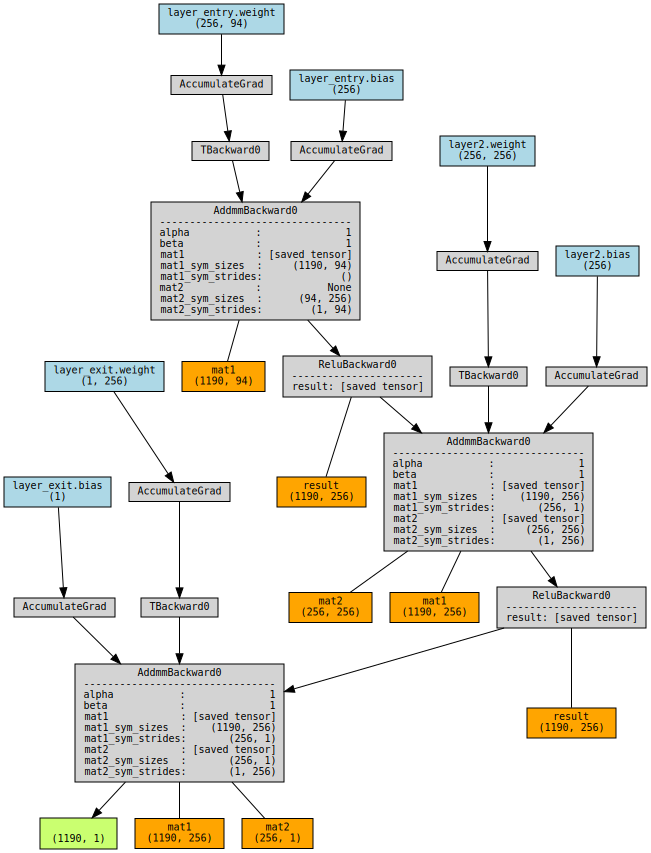

In [30]:
# Convert dataframes to dataset
class MyDataset(Dataset):
    def __init__(self, input_df, target_df):
        self.input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)
        self.target_tensor = torch.tensor(target_df.values, dtype=torch.float32).to(device)
    def __len__(self):
        return len(self.input_tensor) # Number of rows in our input dataset
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.target_tensor[idx]
    def get_tensors(self):
        return self.input_tensor, self.target_tensor

# Model definition
class MyModel(nn.Module):
    def __init__(self, in_features):
        super(MyModel, self).__init__()
        hidden_dim = 256 # start smaller than the input dimension size and larger than the output dimension size
        self.layer_entry = nn.Linear(in_features, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        # self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer_exit = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = nn.functional.relu(self.layer_entry(x))
        x = nn.functional.relu(self.layer2(x))
        # x = nn.functional.relu(self.layer3(x))
        x = self.layer_exit(x)
        return x

dataset = MyDataset(features_encoded_df, target_df)
model = MyModel(input_size).to(device)
input_tensor, target_tensor = dataset.get_tensors()
make_dot(model(input_tensor), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [31]:
# Training Tuning Parameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 2000
# Choose the best loss and optimizer functions
criterion = nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Split the data and setup the data loaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'Training Size = {train_size}')
print(f'Test Size = {test_size}')

Training Size = 952
Test Size = 238


Epoch 100 (5%), Loss: 207
Epoch 200 (10%), Loss: 94
Epoch 300 (15%), Loss: 62
Epoch 400 (20%), Loss: 43
Epoch 500 (25%), Loss: 29
Epoch 600 (30%), Loss: 25
Epoch 700 (35%), Loss: 21
Epoch 800 (40%), Loss: 18
Epoch 900 (45%), Loss: 16
Epoch 1000 (50%), Loss: 15
Epoch 1100 (55%), Loss: 12
Epoch 1200 (60%), Loss: 11
Epoch 1300 (65%), Loss: 11
Epoch 1400 (70%), Loss: 10
Epoch 1500 (75%), Loss: 9
Epoch 1600 (80%), Loss: 8
Epoch 1700 (85%), Loss: 8
Epoch 1800 (90%), Loss: 7
Epoch 1900 (95%), Loss: 7
Epoch 2000 (100%), Loss: 6


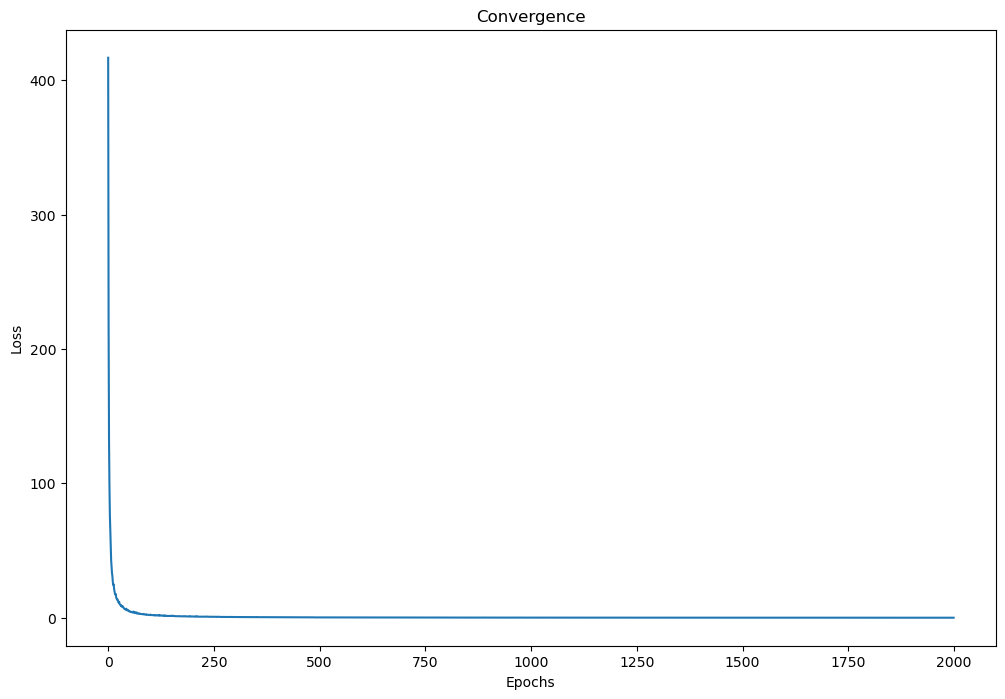

In [32]:
# Train the model and plot convergence
def train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs):
    plot_losses = []
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            input_tensor, target_tensor = data
            optimizer.zero_grad()
            output_tensor = model(input_tensor)
            loss = criterion(output_tensor, target_tensor)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                input_tensor, target_tensor = data
                output_tensor = model(input_tensor)
                loss = criterion(output_tensor, target_tensor)
                total_loss += loss.item()
        if epoch % (num_epochs/20) == 0:
            percentComplete = epoch/num_epochs*100
            print(f'Epoch {epoch} ({percentComplete:.0f}%), Loss: {total_loss/epoch*100:.0f}') # *100 to add some precision
        plot_losses.append(total_loss/epoch)
    return plot_losses

plot_losses = train(train_dataloader, test_dataloader, model, criterion, optimizer, num_epochs)
plt.figure(figsize=(12,8))
plt.title("Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(plot_losses)

In [33]:
# Save model to file
path = '../outputs/stock_price_model.pth'
torch.save(model, path)
saved_model = torch.load(path)

def getAccuracyPercentage(list1, list2):
    mean_abs_diff = np.mean(np.abs(list1 - list2))
    mean_orig = np.mean([list1, list2])
    return 100 - mean_abs_diff / mean_orig * 100

# Test the model's accuracy
saved_model.eval()
input_tensor, target_tensor = test_dataset.dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
accuracy_percent = getAccuracyPercentage(y_predicted, y_actual)
print(f"Test Accuracy: {accuracy_percent:>0.1f}%")

Test Accuracy: 82.5%


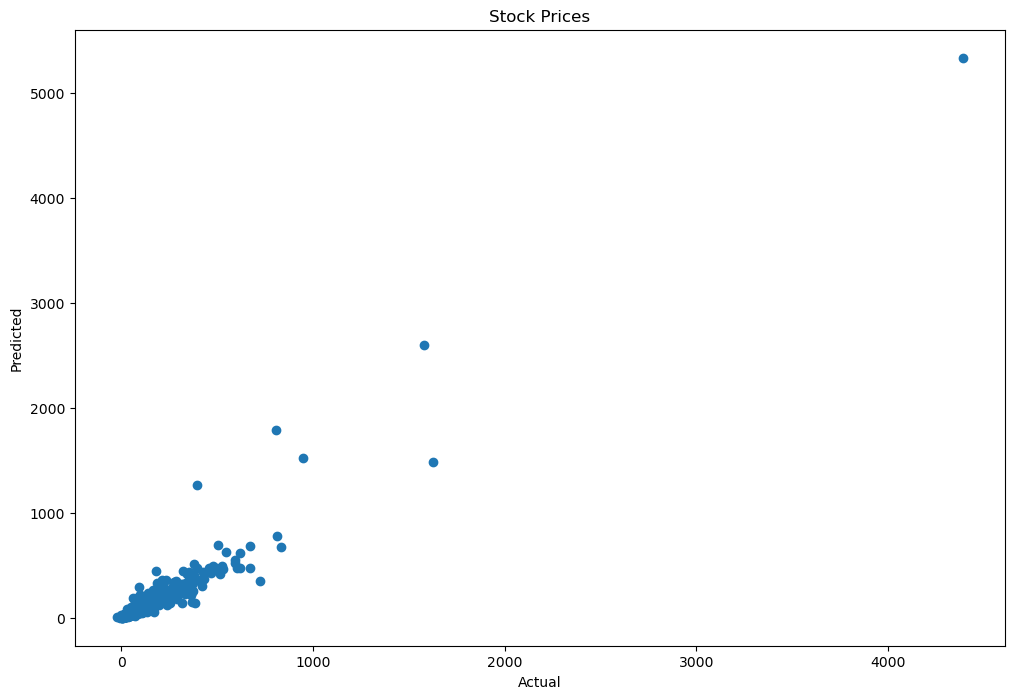

In [34]:
# Scatter plot results to show accuracy (45% upward, rightward slope scatter plot)
plt.figure(figsize=(12,8))
plt.scatter(y_predicted, y_actual)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Stock Prices")
plt.show()

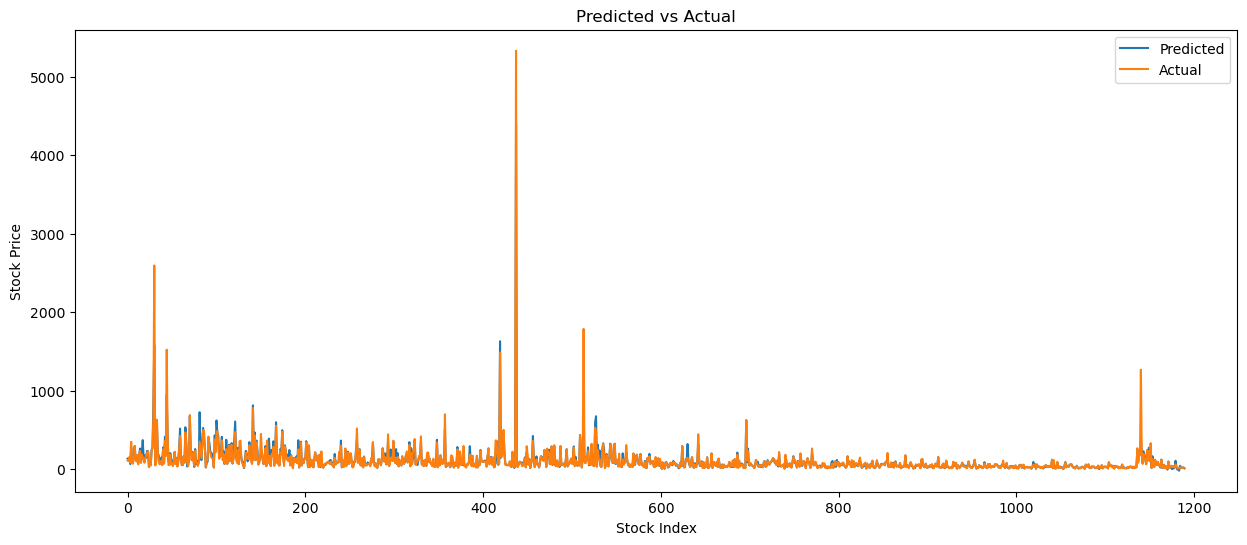

In [35]:
# Show accuracy by overlaying actual vs pridicted prices
# Orange on top helps underpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.title("Predicted vs Actual")
plt.xlabel("Stock Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

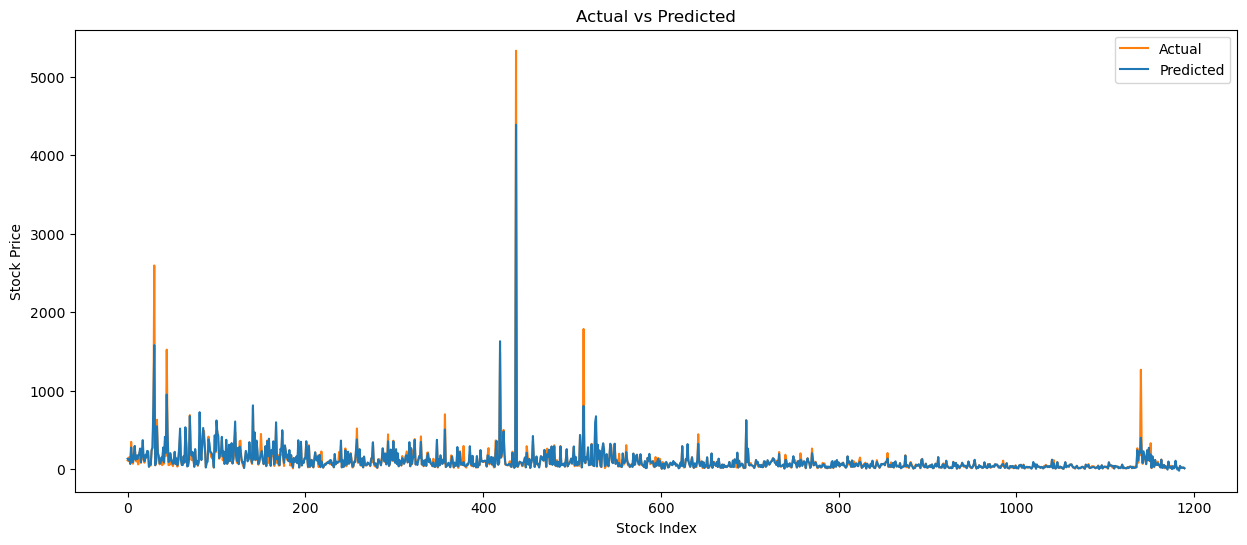

In [36]:
# Inverse the plot so blue is on top.  This helps high overpriced stocks stand out
plt.figure(figsize=(15,6))
plt.plot(y_actual, color='#ff7f0e', label='Actual')
plt.plot(y_predicted, color='#1f77b4', label='Predicted')
plt.title("Actual vs Predicted")
plt.xlabel("Stock Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [37]:
# Run predictions for the full dataset
input_tensor, target_tensor = dataset.get_tensors()
with torch.no_grad():
    y_prediction_tensor = saved_model(input_tensor)
    y_predicted = y_prediction_tensor.detach().cpu().numpy()
    y_actual = target_tensor.detach().cpu().numpy()
    predicted_price_difference = (y_predicted - y_actual) / ((y_predicted + y_actual) / 2) * 100
    accuracy_percent = 100-abs(np.average(predicted_price_difference))
# Generate new table with both actual and predicted prices using the original dataframe which contained all columns including those not used in training
output_df = df.copy()
target_index = 5
output_df.insert(target_index+1, 'Predicted Price', y_predicted)
output_df.insert(target_index+2, '% Difference', predicted_price_difference)
output_df.to_excel('../outputs/stock_prices.xlsx', index=False)
# Sort so the stocks to buy go to the top and the stocks to sell go to the bottom
output_df = output_df.sort_values(by='% Difference', ascending=False).reset_index(drop=True)
# Stocks to buy
output_df.head()

,Symbol,Company Name,Company Headquarters Location,Sector,Industry,Security Price,Predicted Price,% Difference,Market Capitalization (billions),Earnings Per Share,...,Book Value,Return on Equity (TTM),Free Cash Flow,EPS Growth (proj this yr vs. last yr),Valuation,Quality,Growth Stability,Financial Health,Summary Score,Institutional Ownership
0,GPRK,GeoPark Ltd,Chile,Energy,"Oil, Gas & Consumable Fuels",13.1600,-22.186111,783.196899,0.79736,3.463158,...,1.362319,20880.1597,282.973,266.96429,95.0,91.0,70.0,74.0,Neutral,45.5218
1,AMBP,Ardagh Metal Packaging SA,Luxembourg,Materials,Containers & Packaging,4.3400,-8.365021,631.302185,2.70000,0.398165,...,0.881027,59.4184,-482.000,55.33333,49.0,29.0,95.0,60.0,Very Bearish,19.0414
2,FSK,FS KKR Capital Corp,United States of America,Financials,Capital Markets,19.5700,73.088104,115.517380,5.61000,0.730224,...,24.820221,2.7335,78.000,2.11604,20.0,21.0,24.0,37.0,Bearish,34.4520
3,VTRS,Viatris Inc,United States of America,Health Care,Pharmaceuticals,10.6966,37.106834,110.495125,13.00000,1.697873,...,17.099512,10.3274,2546.600,-12.48503,98.0,95.0,53.0,97.0,Bullish,74.7458
4,ADT,ADT Inc,United States of America,Consumer Discretionary,Diversified Consumer Services,7.6400,23.835907,102.909874,7.08000,0.190050,...,3.719644,5.2084,976.000,104.16667,94.0,89.0,42.0,79.0,Bullish,87.3993


In [38]:
# Stocks to sell
output_df.tail()

,Symbol,Company Name,Company Headquarters Location,Sector,Industry,Security Price,Predicted Price,% Difference,Market Capitalization (billions),Earnings Per Share,...,Book Value,Return on Equity (TTM),Free Cash Flow,EPS Growth (proj this yr vs. last yr),Valuation,Quality,Growth Stability,Financial Health,Summary Score,Institutional Ownership
1185,CLB,Core Laboratories NV,Netherlands,Energy,Energy Equipment & Services,25.01,6.292284,-119.593300,1.19000,0.420336,...,3.866298,11.2166,14.740,67.71930,17.0,31.0,18.0,14.0,Bearish,97.4338
1186,RPT,RPT Realty,United States of America,Real Estate,Equity Real Estate Investment Trusts (REITs),10.31,1.903018,-137.672470,0.91499,0.888793,...,9.891017,9.5043,97.673,-99.43820,71.0,69.0,94.0,86.0,Neutral,96.0011
1187,OEC,Orion Engineered Carbons SA,Luxembourg,Materials,Chemicals,26.01,-1.796360,-229.675171,1.58000,1.734000,...,7.497881,25.5488,-151.800,29.59184,36.0,34.0,61.0,59.0,Bullish,92.0958
1188,LBC,Luther Burbank Corp,United States of America,Financials,Thrifts & Mortgage Finance,11.51,-1.724190,-270.477142,0.59390,1.576712,...,13.214696,11.8863,84.404,-42.67516,61.0,23.0,19.0,12.0,Bullish,13.8108
1189,NVGS,Navigator Holdings Ltd,United Kingdom,Energy,"Oil, Gas & Consumable Fuels",13.43,-6.835394,-614.605164,1.04000,0.029998,...,14.949963,0.2426,122.679,91.46341,53.0,46.0,29.0,33.0,Bearish,18.7147
